# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('./Udacity_AZDIAS_Subset.csv', delimiter=';')
original_azdias = azdias.copy()

# Load in the feature summary file.
feat_info = pd.read_csv('./AZDIAS_Feature_Summary.csv', delimiter=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print('azdias.shape', azdias.shape)
print('feat_info.shape', feat_info.shape)
print(feat_info.head())
print(azdias.head())


azdias.shape (891221, 85)
feat_info.shape (85, 4)
              attribute information_level         type missing_or_unknown
0              AGER_TYP            person  categorical             [-1,0]
1  ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2             ANREDE_KZ            person  categorical             [-1,0]
3         CJT_GESAMTTYP            person  categorical                [0]
4     FINANZ_MINIMALIST            person      ordinal               [-1]
   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3 

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [63]:
# Identify missing or unknown data values and convert them to NaNs.
import re

def RepresentsInt(s):
    try: 
        int(s)
        return True
    except ValueError:
        return False

print(feat_info.head(1))

for feat in feat_info.values:
    index = feat[0]
    list_missing = re.sub(r'(\[)|(\])', '', feat[3]).split(',')
    #print('-- ',index, list_missing)
    for each_missing in list_missing:
        #print('------ ',each_missing)
        if RepresentsInt(each_missing): each_missing = int(each_missing)
        azdias[index] = azdias[index].replace(each_missing, np.NaN)

print(azdias.head(5))
 

  attribute information_level         type missing_or_unknown
0  AGER_TYP            person  categorical             [-1,0]
   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0       NaN                   2.0          1            2.0   
1       NaN                   1.0          2            5.0   
2       NaN                   3.0          2            3.0   
3       2.0                   4.0          2            2.0   
4       NaN                   3.0          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

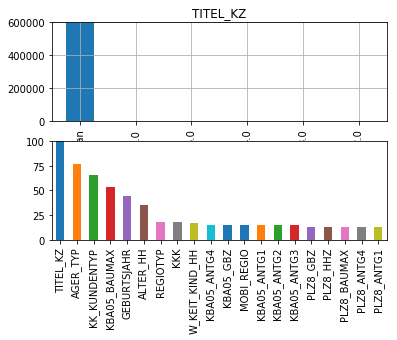

In [64]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

fig, (ax1, ax2) = plt.subplots(nrows=2)

ax1.set_ylim(0,600000)
ax2.set_ylim(0,100)


counts = azdias['TITEL_KZ'].value_counts(dropna=False)
counts.plot.bar(title='TITEL_KZ', grid=True, ax=ax1)

x = round((azdias.isna().sum()*100)/len(azdias),2)
x.sort_values(ascending=False).head(20).plot.bar(ax=ax2)


In [65]:
# Investigate patterns in the amount of missing data in each column.

x = azdias.isna().sum()
x.sort_values(ascending=False).head(6)

TITEL_KZ        889061
AGER_TYP        685843
KK_KUNDENTYP    584612
KBA05_BAUMAX    476524
GEBURTSJAHR     392318
ALTER_HH        310267
dtype: int64

In [66]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)


azdias=azdias.drop(['TITEL_KZ'], axis=1)
azdias=azdias.drop(['AGER_TYP'], axis=1)
azdias=azdias.drop(['KK_KUNDENTYP'], axis=1)
azdias=azdias.drop(['KBA05_BAUMAX'], axis=1)
azdias=azdias.drop(['GEBURTSJAHR'], axis=1)
azdias=azdias.drop(['ALTER_HH'], axis=1)
azdias.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column


According to the observation on the dataset above, we found many columns has missing values. Majority of these columns with missing value has approximately 10% to 25% missing value while six exceptional columns including TITEL_KZ, AGER_TYP, KK_KUNDENTYP, KBA05_BAUMAX, GEBURTSJAHR, and ALTER_HH are the outstanding outlier. Therefore, we decided to remove these six columns from the azdias dataset.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

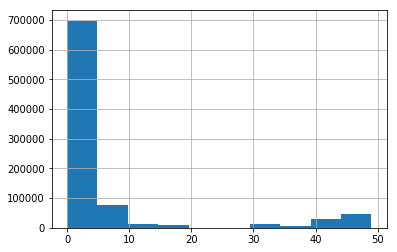

In [67]:
# How much data is missing in each row of the dataset?
x = azdias.isna().sum(axis=1)
x.sort_values(ascending=False).hist()


In [68]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

threshold = 30

df_more = azdias[azdias.isna().sum(axis=1)>=threshold]
df_less = azdias[azdias.isna().sum(axis=1)<threshold]

print('count df_more', df_more['ZABEOTYP'].count())
print('count df_less', df_less['ZABEOTYP'].count())


count df_more 93160
count df_less 798061


ZABEOTYP      0
SEMIO_REL     0
SEMIO_MAT     0
SEMIO_VERT    0
SEMIO_LUST    0
dtype: int64


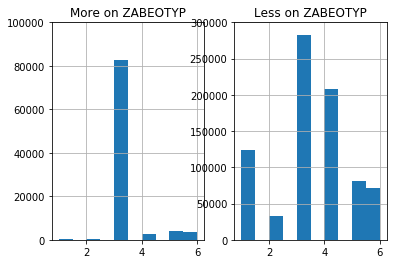

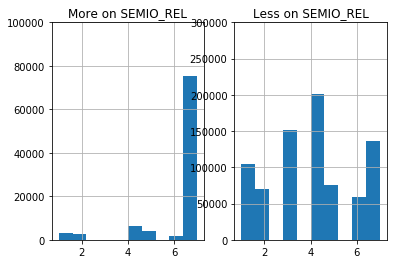

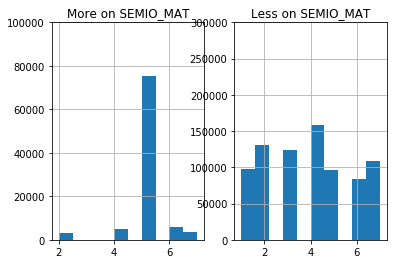

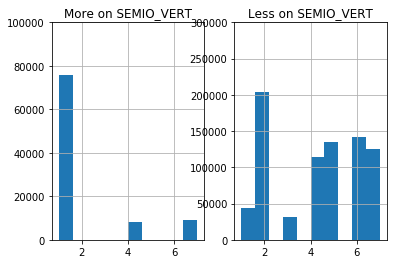

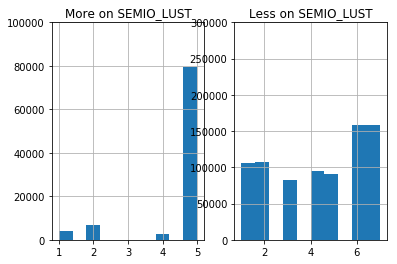

In [69]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# find five columns with least missing values
xa = azdias.isna().sum()
xa = xa.sort_values(ascending=True).head(5)
print(xa)


def hist_plot(i):
    fig, (ax1, ax2) = plt.subplots(ncols=2)
    ax1.set_ylim(0,100000)
    ax1.set_title('More on {}'.format(i))
    ax2.set_ylim(0,300000)
    ax2.set_title('Less on {}'.format(i))
    df_more[i].hist(ax=ax1)
    df_less[i].hist(ax=ax2)

for i, val in xa.items():
    hist_plot(i)

good_dataset = df_less.copy()

#### Discussion 1.1.3: Assess Missing Data in Each Row

Although considering five columns with no missing value including ZABEOTYP, SEMIO_REL, SEMIO_MAT, SEMIO_VERT, and SEMIO_LUST, we found the outstanding outlier on the dataset with lots of missing values while the values of the dataset with fewer missing values are well distributed (much better than the other dataset). Therefore, we may consider to use the dataset with fewer missing values.


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [70]:
# How many features are there of each data type?

#print(feat_info[feat_info['type']=='ordinal'].count())

feat_info.groupby(['type']).count()

,attribute,information_level,missing_or_unknown
type,,,
categorical,21,21,21
interval,1,1,1
mixed,7,7,7
numeric,7,7,7
ordinal,49,49,49


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [71]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
#print(feat_info[feat_info['type']=='categorical']['attribute'])

print(good_dataset.groupby(['ANREDE_KZ'])['LP_FAMILIE_FEIN'].count())
print(good_dataset.groupby(['CJT_GESAMTTYP'])['LP_FAMILIE_FEIN'].count())
print(good_dataset.groupby(['FINANZTYP'])['LP_FAMILIE_FEIN'].count())
print(good_dataset.groupby(['GFK_URLAUBERTYP'])['LP_FAMILIE_FEIN'].count())
print(good_dataset.groupby(['GREEN_AVANTGARDE'])['LP_FAMILIE_FEIN'].count())
print(good_dataset.groupby(['LP_FAMILIE_FEIN'])['LP_FAMILIE_GROB'].count())
print(good_dataset.groupby(['LP_FAMILIE_GROB'])['LP_FAMILIE_FEIN'].count())
print(good_dataset.groupby(['LP_STATUS_FEIN'])['LP_FAMILIE_FEIN'].count())
print(good_dataset.groupby(['LP_STATUS_GROB'])['LP_FAMILIE_FEIN'].count())
print(good_dataset.groupby(['NATIONALITAET_KZ'])['LP_FAMILIE_FEIN'].count())
print(good_dataset.groupby(['SHOPPER_TYP'])['LP_FAMILIE_FEIN'].count())
print(good_dataset.groupby(['SOHO_KZ'])['LP_FAMILIE_FEIN'].count())
print(good_dataset.groupby(['VERS_TYP'])['LP_FAMILIE_FEIN'].count())
print(good_dataset.groupby(['ZABEOTYP'])['LP_FAMILIE_FEIN'].count())
print(good_dataset.groupby(['OST_WEST_KZ'])['LP_FAMILIE_FEIN'].count())
print(good_dataset.groupby(['CAMEO_DEUG_2015'])['LP_FAMILIE_FEIN'].count())
print(good_dataset.groupby(['CAMEO_DEU_2015'])['LP_FAMILIE_FEIN'].count())

# non-numeric binary --> OST_WEST_KZ    (O, W)
# multi-level categorical --> CAMEO_DEU_2015

'''
dropped fields: TITEL_KZ, AGER_TYP, KK_KUNDENTYP, KBA05_BAUMAX, GEBURTSJAHR, ALTER_HH

0             AGER_TYP    --dropped
2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
40            TITEL_KZ    --dropped
41            VERS_TYP
42            ZABEOTYP
47        KK_KUNDENTYP    --dropped
52         GEBAEUDETYP    --dropped
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
'''


ANREDE_KZ
1    366525
2    400068
Name: LP_FAMILIE_FEIN, dtype: int64
CJT_GESAMTTYP
1.0     88921
2.0    133118
3.0    144684
4.0    193301
5.0    106958
6.0     99611
Name: LP_FAMILIE_FEIN, dtype: int64
FINANZTYP
1    189908
2     99912
3     43443
4     53813
5    100767
6    278750
Name: LP_FAMILIE_FEIN, dtype: int64
GFK_URLAUBERTYP
1.0      49161
2.0      42609
3.0      51188
4.0      58337
5.0      68058
6.0      24921
7.0      39367
8.0      80776
9.0      55664
10.0     98825
11.0     73025
12.0    124662
Name: LP_FAMILIE_FEIN, dtype: int64
GREEN_AVANTGARDE
0    597391
1    169202
Name: LP_FAMILIE_FEIN, dtype: int64
LP_FAMILIE_FEIN
1.0     402556
2.0      98555
3.0       4688
4.0      11574
5.0      11167
6.0       8526
7.0      19575
8.0      21780
9.0      10452
10.0    128974
11.0     48746
Name: LP_FAMILIE_GROB, dtype: int64
LP_FAMILIE_GROB
1.0    402556
2.0     98555
3.0     27429
4.0     49881
5.0    188172
Name: LP_FAMILIE_FEIN, dtype: int64
LP_STATUS_FEIN
1.0     198840


'\ndropped fields: TITEL_KZ, AGER_TYP, KK_KUNDENTYP, KBA05_BAUMAX, GEBURTSJAHR, ALTER_HH\n\n0             AGER_TYP    --dropped\n2            ANREDE_KZ\n3        CJT_GESAMTTYP\n10           FINANZTYP\n12     GFK_URLAUBERTYP\n13    GREEN_AVANTGARDE\n17     LP_FAMILIE_FEIN\n18     LP_FAMILIE_GROB\n19      LP_STATUS_FEIN\n20      LP_STATUS_GROB\n21    NATIONALITAET_KZ\n38         SHOPPER_TYP\n39             SOHO_KZ\n40            TITEL_KZ    --dropped\n41            VERS_TYP\n42            ZABEOTYP\n47        KK_KUNDENTYP    --dropped\n52         GEBAEUDETYP    --dropped\n55         OST_WEST_KZ\n57     CAMEO_DEUG_2015\n58      CAMEO_DEU_2015\n'

In [72]:
# Re-encode categorical variable(s) to be kept in the analysis.


# non-numeric binary --> OST_WEST_KZ    (O, W)
good_dataset['OST_WEST_KZ'] = good_dataset['OST_WEST_KZ'].apply(lambda x: 1 if x=='W' else 0)
print(good_dataset.groupby('OST_WEST_KZ')['LP_LEBENSPHASE_FEIN'].count())

# multi-level categorical --> CAMEO_DEU_2015
good_dataset = pd.get_dummies(data=good_dataset, columns=['CAMEO_DEU_2015'])
good_dataset.describe()


OST_WEST_KZ
0    160653
1    587175
Name: LP_LEBENSPHASE_FEIN, dtype: int64


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
count,795258.000000,798061.000000,793316.000000,798061.000000,798061.000000,798061.000000,798061.000000,798061.000000,798061.000000,798061.000000,...,798061.000000,798061.000000,798061.000000,798061.000000,798061.000000,798061.000000,798061.000000,798061.000000,798061.000000,798061.000000
mean,2.795412,1.521485,3.502893,3.058917,2.716047,3.432892,2.840955,2.658348,3.114102,3.797751,...,0.005805,0.065707,0.041894,0.038835,0.022023,0.025740,0.034679,0.031310,0.035828,0.007993
std,1.018409,0.499538,1.537612,1.377577,1.485090,1.376866,1.472782,1.399530,1.408109,2.084705,...,0.075971,0.247769,0.200347,0.193203,0.146760,0.158358,0.182966,0.174153,0.185861,0.089046
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,2.000000,4.000000,3.000000,3.000000,4.000000,3.000000,2.000000,3.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,6.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,6.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Discussion 1.2.1: Re-Encode Categorical Features

We explored each categorical features. Most features are in the numerical format except two features including OST_WEST_KZ and CAMEO_DEU_2015. When we looked closely into these features, we find OST_WEST_KZ feature is non-numerical binary type; therefore, we can easily map it into numerical binary field with apply function in pandas dataframe. For the other CAMEO_DEU_2015 feature, it is multi-level categorical; hence, we have used one-hot encoding (get_dummies function) to reencode the category.


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [73]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
import math

final_dataset = good_dataset.copy()

def mapping_e(i):
    if math.isnan(i): return 0,0
    a,b = 0, 0
    if int(i) in [1, 3, 5, 8, 10, 12, 14]: a = 1
    if int(i) in [1,2]: b = 40
    elif int(i) in [3,4]: b = 50
    elif int(i) in [5,6,7]: b = 60
    elif int(i) in [8,9]: b = 70
    elif int(i) in [10,11,12,13]: b = 80
    elif int(i) in [14,15]: b = 90
    return a, b

final_dataset["PRAEGENDE_JUGENDJAHRE_dec"], final_dataset["PRAEGENDE_JUGENDJAHRE_mov"] = zip(*final_dataset["PRAEGENDE_JUGENDJAHRE"].map(mapping_e))
final_dataset = final_dataset.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1)

final_dataset.shape

(798061, 123)

In [74]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
import math

def mapping_f(i):
    if isinstance(i, str): 
        i = int(i)
    else:
        return 0,0
    a = math.floor(i/10)
    b = i % 10
    return a, b

final_dataset["CAMEO_INTL_2015_w"], final_dataset["CAMEO_INTL_2015_l"] = zip(*final_dataset["CAMEO_INTL_2015"].map(mapping_f))
final_dataset = final_dataset.drop(['CAMEO_INTL_2015'], axis=1)

final_dataset.shape


(798061, 124)

#### Discussion 1.2.2: Engineer Mixed-Type Features

We did research on additional mixed type features and find interesting information in particular for PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 features.

In the case of PRAEGENDE_JUGENDJAHRE feature, it combines two importants information which is 1) generation by decade, and 2) movement. We explored further into Data_Dictionary.md to collect information that we can map the feature and engineer it into two new variables via mapping_e function.

For the CAMEO_INTL_2015 feature, it seems much simpler as the feature information consisted in the first and second digits. Therefore, we can extract these digits into two new variables via mapping_f function.  

After we engineered the new variables, we then dropped the original features to avoid confusion.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [75]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

final_dataset.head()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_dec,PRAEGENDE_JUGENDJAHRE_mov,CAMEO_INTL_2015_w,CAMEO_INTL_2015_l
1,1.0,2,5.0,1,5,2,5,4,5,1,...,0,0,0,0,0,0,1,90,5,1
2,3.0,2,3.0,1,4,1,2,3,5,1,...,0,0,0,0,0,0,0,90,2,4
3,4.0,2,2.0,4,2,5,2,1,2,6,...,0,0,0,0,0,0,1,70,1,2
4,3.0,1,5.0,4,3,4,1,3,2,5,...,0,0,0,0,0,0,1,70,4,3
5,1.0,2,2.0,3,1,5,2,2,5,2,...,0,0,0,0,0,0,1,50,5,4


In [76]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [4]:
import re, math

'''
DEFINE REUSE FUNCTIONS
'''

def RepresentsInt(s):
    try: 
        int(s)
        return True
    except ValueError:
        return False

def mapping_e(i):
    if math.isnan(i): return 0,0
    a,b = 0, 0
    if int(i) in [1, 3, 5, 8, 10, 12, 14]: a = 1
    if int(i) in [1,2]: b = 40
    elif int(i) in [3,4]: b = 50
    elif int(i) in [5,6,7]: b = 60
    elif int(i) in [8,9]: b = 70
    elif int(i) in [10,11,12,13]: b = 80
    elif int(i) in [14,15]: b = 90
    return a, b

def mapping_f(i):
    if isinstance(i, str): 
        i = int(i)
    else:
        return 0,0
    a = math.floor(i/10)
    b = i % 10
    return a, b

def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for feat in feat_info.values:
        index = feat[0]
        list_missing = re.sub(r'(\[)|(\])', '', feat[3]).split(',')
        for each_missing in list_missing:
            if RepresentsInt(each_missing): each_missing = int(each_missing)
            df[index] = df[index].replace(each_missing, np.NaN)
    # remove selected columns and rows, ...
    # drop column outlier
    df=df.drop(['TITEL_KZ'], axis=1)
    df=df.drop(['AGER_TYP'], axis=1)
    df=df.drop(['KK_KUNDENTYP'], axis=1)
    df=df.drop(['KBA05_BAUMAX'], axis=1)
    df=df.drop(['GEBURTSJAHR'], axis=1)
    df=df.drop(['ALTER_HH'], axis=1)
    # drop row outlier
    threshold = 30
    df = df[df.isna().sum(axis=1)<threshold]
    # select, re-encode, and engineer column values.
    # reencode categorical value
    # non-numeric binary --> OST_WEST_KZ    (O, W)
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].apply(lambda x: 1 if x=='W' else 0)
    # multi-level categorical --> CAMEO_DEU_2015
    df = pd.get_dummies(data=df, columns=['CAMEO_DEU_2015'])
    # engineer mixed type features
    df["PRAEGENDE_JUGENDJAHRE_dec"], df["PRAEGENDE_JUGENDJAHRE_mov"] = zip(*df["PRAEGENDE_JUGENDJAHRE"].map(mapping_e))
    df = df.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1)
    df["CAMEO_INTL_2015_w"], df["CAMEO_INTL_2015_l"] = zip(*df["CAMEO_INTL_2015"].map(mapping_f))
    df = df.drop(['CAMEO_INTL_2015'], axis=1)
    # Return the cleaned dataframe.
    return df


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [5]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
def impute_data(df):
    from sklearn.preprocessing import Imputer
    fill_NaN = Imputer(missing_values=np.nan, strategy='most_frequent', axis=1)
    imputed_DF = pd.DataFrame(fill_NaN.fit_transform(df))
    imputed_DF.columns = df.columns
    imputed_DF.index = df.index
    return imputed_DF

cleaned_azdias = clean_data(original_azdias)
impute_azdias = impute_data(cleaned_azdias)


In [6]:
# Apply feature scaling to the general population demographics data.

def scale_data(df):
    from sklearn.preprocessing import StandardScaler
    final_features = StandardScaler().fit_transform(df.values)
    scaled_DF = pd.DataFrame(final_features)
    scaled_DF.columns = df.columns
    scaled_DF.index = df.index
    return scaled_DF

final_features = scale_data(impute_azdias)

print(final_features)
print(final_features.shape)

        ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  FINANZ_MINIMALIST  \
1                  -1.733618   0.957914       0.975219          -1.494594   
2                   0.208165   0.957914      -0.309710          -1.494594   
3                   1.179056   0.957914      -0.952175           0.683144   
4                   0.208165  -1.043935       0.975219           0.683144   
5                  -1.733618   0.957914      -0.952175          -0.042768   
6                  -0.762727   0.957914       0.975219          -1.494594   
7                  -1.733618  -1.043935      -0.309710          -0.042768   
8                   0.208165  -1.043935      -0.309710           0.683144   
9                   0.208165   0.957914       0.332754          -0.768681   
10                  0.208165   0.957914      -1.594639          -0.768681   
12                  0.208165  -1.043935       1.617683           1.409057   
13                 -1.733618   0.957914       0.975219          -1.494594   

### Discussion 2.1: Apply Feature Scaling

1) With the fact that we remove majority of unkown data, there is still some missing values data. Therefore, we impute the data with most-frequent strategy to ensure the imputer fill the similar format of the data.

2) Before applying PCA, it's also important to scaling the data to have zero mean with 1 standard deviation. Therefore, we use StandardScaler in sklearn.preprocessing to achieve this task.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [7]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
def do_pca(n_components, data):
    X = StandardScaler().fit_transform(data)
    pca = PCA(n_components)
    X_pca = pca.fit_transform(X)
    return pca, X_pca

pca, X_pca = do_pca(62, final_features)


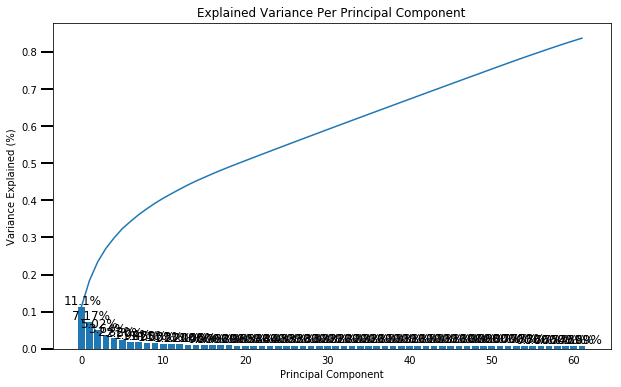

In [9]:
# Investigate the variance accounted for by each principal component.

def scree_plot(pca):
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    
scree_plot(pca)

In [8]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca, X_pca = do_pca(50, final_features)

### Discussion 2.2: Perform Dimensionality Reduction

According to the plot above, we chose PCA with 50 components to retain for the next step. This yields expected variance explained (> 70%) while sharply reducing dimensionality.


### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

CAMEO_DEUG_2015       0.1994
CAMEO_INTL_2015_w     0.1965
HH_EINKOMMEN_SCORE    0.1952
PLZ8_ANTG3            0.1928
PLZ8_ANTG4            0.1904
PLZ8_BAUMAX           0.1844
PLZ8_ANTG1           -0.1805
MOBI_REGIO           -0.1855
FINANZ_MINIMALIST    -0.1894
KBA05_ANTG1          -0.1912
LP_STATUS_GROB       -0.2107
LP_STATUS_FEIN       -0.2138
Name: Dimension 1, dtype: float64


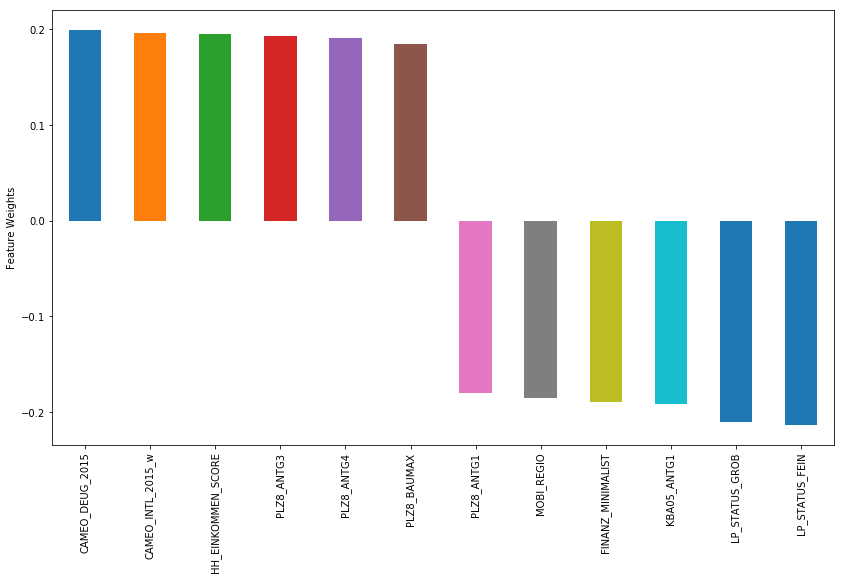

In [17]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def plot_pca_features(full_dataset, pca, index_dimension, number_of_top_features):
	# Dimension indexing
	dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
	# PCA components
	components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
	components.index = dimensions
	components = components.loc[ 'Dimension {}'.format(index_dimension) , : ]
	#components = components.abs().sort_values(ascending=False).head(number_of_top_features)
	components = components.sort_values(ascending=False)
	fig, ax = plt.subplots(figsize = (14,8))
	# Plot the feature weights as a function of the components
	final_components = pd.concat([components.head(number_of_top_features), components.tail(number_of_top_features)])
	final_components.plot(ax = ax, kind = 'bar');
	ax.set_ylabel("Feature Weights")
	print(final_components)
	#return components

# social status, wealth, net income, house region
plot_pca_features(final_features, pca, 1, 6)

ALTERSKATEGORIE_GROB     0.2694
FINANZ_VORSORGER         0.2394
SEMIO_ERL                0.2354
SEMIO_LUST               0.1910
RETOURTYP_BK_S           0.1587
FINANZTYP                0.1144
SEMIO_KULT              -0.2229
FINANZ_UNAUFFAELLIGER   -0.2307
SEMIO_PFLICHT           -0.2365
SEMIO_TRADV             -0.2393
FINANZ_SPARER           -0.2493
SEMIO_REL               -0.2631
Name: Dimension 2, dtype: float64


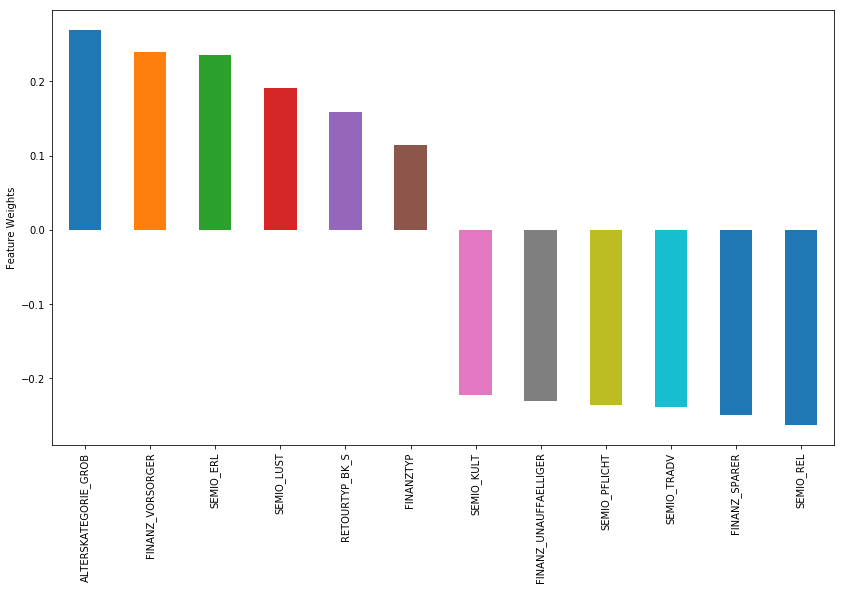

In [16]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

# age, personality topology, financial topology

plot_pca_features(final_features, pca, 2, 6)

SEMIO_VERT           0.3364
SEMIO_SOZ            0.2570
SEMIO_FAM            0.2460
SEMIO_KULT           0.2330
FINANZ_MINIMALIST    0.1584
FINANZTYP            0.1226
FINANZ_ANLEGER      -0.1843
SEMIO_RAT           -0.2127
SEMIO_KRIT          -0.2695
SEMIO_DOM           -0.3058
SEMIO_KAEM          -0.3299
ANREDE_KZ           -0.3628
Name: Dimension 3, dtype: float64


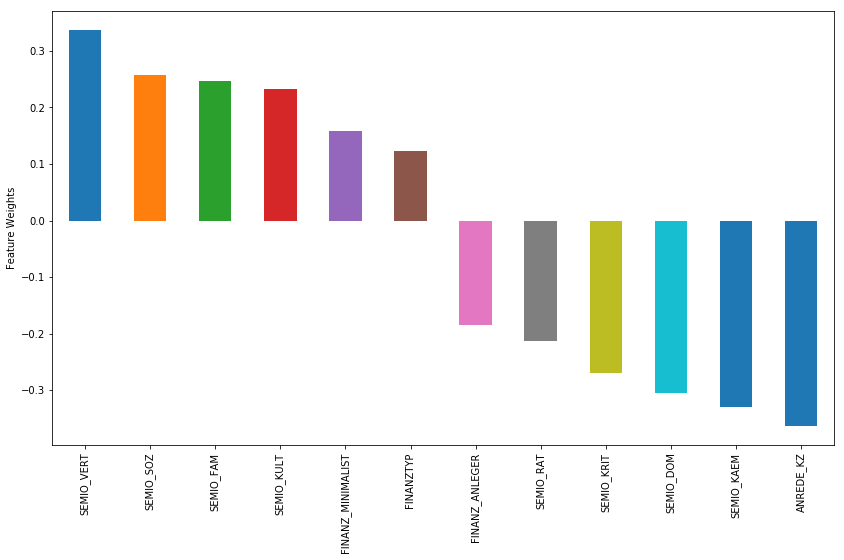

In [18]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

# gender, etc.

plot_pca_features(final_features, pca, 3, 6)


### Discussion 2.3: Interpret Principal Components

The calculated weight represents the direction of the corresponding feature to the principal component. When the value is greater in the positive side, the principal component is more influenced by the feature; for those in negative values, it has greater impact to the principal component but in opposite direction. Moreover, here is our observation for each dimension:

Dimension1 looks more focused into life/weath status. The  dominant positive features are such as CAMEO_DEUG_2015, CAMEO_INTL_2015 (life topology), and negative features are such as LP_STATUS_FEIN, LP_STATUS_GROB (social status).

Dimension2 focused on personality type such as how they spend/saving, religious, events, etc. The positive features are for example ALTERSKATEGORIE_GROB (age), FINANZ_VORSORGER (financial interest, be prepare), SEMIO_ERL (personality, event-oriented); negative features are SEMIO_TRADV (personality, tradional-minded) and SEMIO_REL (personality, religious), FINANZ_SPARER (financial interest.

Dimension3 foocused on social personality on how they connect with society and family, dream, gender, etc. The positive features are such as SEMIO_VERT (Personality, dreamful), SEMIO_SOZ (Personality, socially-minded), SEMIO_FAM (Personality, family-minded); negative features are SEMIO_DOM (dominant-minded), SEMIO_KAEM (combative attitude), ANREDE_KZ (gender)


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [9]:
# Over a number of different cluster counts...
    # run k-means clustering on the data and...   
    # compute the average within-cluster distances.
from sklearn.cluster import KMeans

def get_kmeans_score(data, center):
    kmeans = KMeans(n_clusters=center)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score

scores = []
centers = list(range(1,35))

for center in centers:
    scores.append(get_kmeans_score(X_pca, center))
    

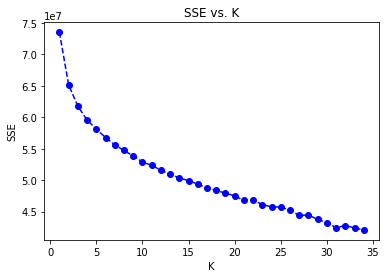

In [10]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');


In [19]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
from sklearn.cluster import KMeans
kmeans24 = KMeans(n_clusters=24)
model24 = kmeans24.fit(X_pca)
label24 = model24.predict(X_pca)
label24.shape

(798061,)

### Discussion 3.1: Apply Clustering to General Population

We plotted the error score versus K; and find the slop starts slowing down from K=25. Therefore, we decided to choose K=24 to segment the population.


### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [20]:
# Load in the customer demographics data.
customers = pd.read_csv('./Udacity_CUSTOMERS_Subset.csv', delimiter=';')
customers.shape

(191652, 85)

In [21]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

cleaned_customers = clean_data(customers)
impute_customers = impute_data(cleaned_customers)
final_customers_features = scale_data(impute_customers)
pca24, X_pca24 = do_pca(50, final_customers_features)
clabel24 = model24.predict(X_pca24)
clabel24.shape

(141725,)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

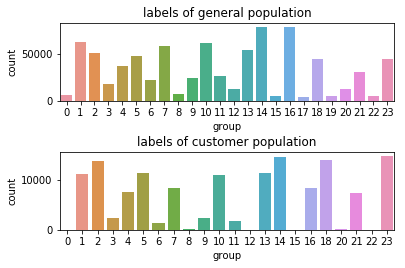

In [22]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
import seaborn as sns

l_pd = pd.DataFrame(label24, columns=['group'])
cl_pd = pd.DataFrame(clabel24, columns=['group'])

fig, (ax1, ax2) = plt.subplots(nrows=2)

fig.tight_layout(pad=3.0)

ax1.set_title('labels of general population')
ax2.set_title('labels of customer population')

sns.countplot(x='group', data=l_pd, ax=ax1)
sns.countplot(x='group', data=cl_pd, ax=ax2)

4     2.580959
3     0.901075
9     0.479469
11    0.361690
22    0.258803
dtype: float64
LP_FAMILIE_GROB              0.3396
LP_FAMILIE_FEIN              0.3369
LP_LEBENSPHASE_GROB          0.3290
LP_LEBENSPHASE_FEIN          0.3213
ANZ_PERSONEN                 0.2911
ORTSGR_KLS9                  0.2085
KONSUMNAEHE                 -0.1078
W_KEIT_KIND_HH              -0.1148
PRAEGENDE_JUGENDJAHRE_dec   -0.1602
BALLRAUM                    -0.1630
WOHNLAGE                    -0.1651
INNENSTADT                  -0.1722
Name: Dimension 4, dtype: float64


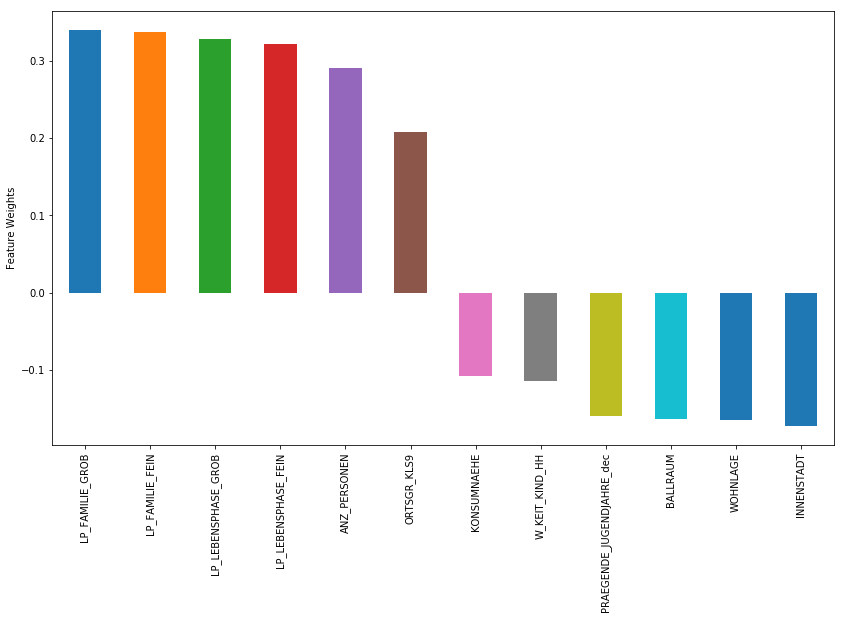

In [28]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# 1. find the overrepresented group
# group#23 (as seen from the chart above)


# 2. find the PC 
# PC#4 is very influenced
group23 = pd.Series(model24.cluster_centers_[23])
group23.sort_values(ascending=False, inplace=True)
print(group23.head(5))


# influence heavily on dimension#4
# let's take a closer look
plot_pca_features(final_features, pca, 4, 6)


28    2.679628
24    1.862132
33    1.851064
16    1.640422
22    1.511659
dtype: float64
CAMEO_DEU_2015_2C    0.3390
CAMEO_DEU_2015_9A    0.3381
CAMEO_DEU_2015_8B    0.2600
CAMEO_DEU_2015_7B    0.2145
CAMEO_DEU_2015_2B    0.1521
CAMEO_DEU_2015_1C    0.1441
CAMEO_DEU_2015_4C   -0.1626
CAMEO_DEU_2015_1A   -0.1779
CAMEO_DEU_2015_8C   -0.2038
CAMEO_DEU_2015_9D   -0.2336
CAMEO_DEU_2015_9C   -0.2846
CAMEO_DEU_2015_4A   -0.3261
Name: Dimension 28, dtype: float64


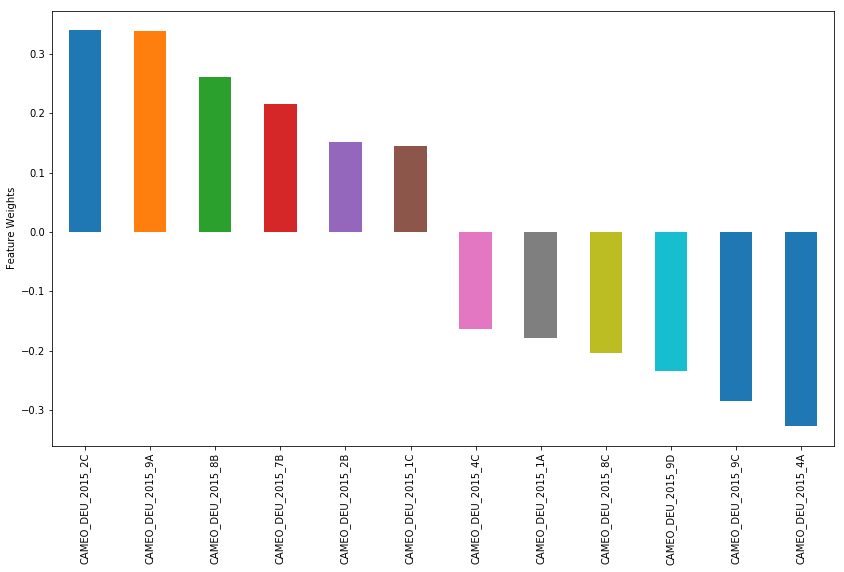

In [33]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# 1. find the underrepresented group
# group#12 (as seen from the chart above)


# 2. find the PC 
# PC#4 is very influenced
group12 = pd.Series(model24.cluster_centers_[12])
group12.sort_values(ascending=False, inplace=True)
print(group12.head(5))


# influence heavily on dimension#4
# let's take a closer look
plot_pca_features(final_features, pca, 28, 6)

### Discussion 3.3: Compare Customer Data to Demographics Data

When consider the proportion of data in each cluster for the customer data to the general population, both trends majorly go with the same trend. There are outstanding overrepresented and underrepresented customer groups.


1. Overrepresented

We can see from the comparisono that cluster#23 is overrepresented. When we looked at the weight in cluster#23, we found that principal component#4 is highly influencing in that particular cluster.

When we look closely, this customer group has a big family staying in the same households. Moreover, their household is pretty close to city/urban center with good quality of neighborhood. The detail of each top features are as followed.

LP_FAMILIE_GROB              0.3396
Family type, rough scale
- 3: single parent (maps to 3-5 in fine scale)
- 4: family (maps to 6-8 in fine scale)
- 5: multiperson household (maps to 9-11 in fine scale)

LP_FAMILIE_FEIN              0.3369
Family type, fine scale
-  9: shared flat
- 10: two-generational household
- 11: multi-generational household

LP_LEBENSPHASE_GROB          0.3290
Life stage, rough scale
- 10: low-income and average earners of higher age from multiperson households
- 11: high-income earners of younger age from multiperson households
- 12: high-income earners of higher age from multiperson households

BALLRAUM                    -0.1630
Distance to nearest urban center
-  1: less than 10 km
-  2: 10 -  20 km
-  3: 20 -  30 km

WOHNLAGE                    -0.1651
Neighborhood quality (or rural flag)
-  1: very good neighborhood
-  2: good neighborhood
-  3: average neighborhood

INNENSTADT                  -0.1722
Distance to city center (downtown)
-  1: in city center
-  2: less than 3 km to city center


2. Underrepresented

We can see from the comparisono that cluster#12 is overrepresented. When we looked at the weight in cluster#12, we found that principal component#28 is highly influencing in that particular cluster.

When we look closely, this customer group is young and mobile. They seems to just starting their life and no family yet. It seems to align as this group does not typical spender for our store. Anyway, the detail of each top features are as followed.

CAMEO_DEU_2015 -- hot encoded features
German CAMEO: Wealth / Life Stage Typology, detailed scale

CAMEO_DEU_2015_2C    0.3390
- 2C: Established gourmet
CAMEO_DEU_2015_9A    0.3381
- 9A: First Shared Apartment
CAMEO_DEU_2015_8B    0.2600
- 8B: Young & Mobile


CAMEO_DEU_2015_9D   -0.2336
- 9D: Mini-Jobber
CAMEO_DEU_2015_9C   -0.2846
- 9C: Afternoon Talk Show
CAMEO_DEU_2015_4A   -0.3261
- 4A: Family Starter


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.